In [8]:
#Reid Glaze
#CSCI 5922
#Lab Report 3

import numpy as np
from datasets import list_datasets, load_dataset

# Load a dataset and print the first example in the training set
dataset = load_dataset('sms_spam')
train = dataset['train']

## Prep the train dataset to samples (input) and labels (output)
train_sms = [x['sms'] for x in train]
train_labels = [x['label'] for x in train]
classes = list(set(train_labels))
print("Classes:", np.unique(train_labels))
from sklearn.model_selection import train_test_split
X_train_samples, X_test_samples, y_train_labels, y_test_labels = train_test_split(train_sms, train_labels, test_size=0.3, random_state=0)
print("Number of samples in train:", len(X_train_samples))
print("Number of samples in test:", len(X_test_samples))


Found cached dataset sms_spam (/Users/reidglaze/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)


  0%|          | 0/1 [00:00<?, ?it/s]

Classes: [0 1]
Number of samples in train: 3901
Number of samples in test: 1673


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TextVectorization
import tensorflow as tf

num_words = 10000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_samples)

# Get our training data word index
#word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train_samples)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
print(maxlen)


# Create our Text Vectorizer to index our vocabulary based on the train samples
vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=maxlen)
text_ds = tf.data.Dataset.from_tensor_slices(X_train_samples).batch(128) ## Read batches of 128 samples
vectorizer.adapt(text_ds)

# Create a map to get the unique list of the vocabulary
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
#print(word_index)

# Vectorize our data (Convert the string data to integer data)
X_train = vectorizer(np.array([[s] for s in X_train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in X_test_samples])).numpy()
#print(X_train)
# from list to numpy array
y_train = np.array(y_train_labels)
y_test = np.array(y_test_labels)
# Create short, long, and medium test sets
indices = (X_test != 0).sum(axis=1).argsort()
X_sorted = X_test[indices]
y_sorted = y_test[indices]
#print(X_sorted)
ind = np.arange(X_sorted.shape[0])
short, medium, long = (np.array_split(ind, 3))
X_test_short = X_sorted[short]
X_test_medium = X_sorted[medium]
X_test_long = X_sorted[long]
y_test_short = y_sorted[short]
y_test_medium = y_sorted[medium]
y_test_long = y_sorted[long]


162


In [10]:
from keras.layers import Embedding
from keras.initializers import Constant
from keras import layers, Input, Model
from sklearn.metrics import precision_score, recall_score

embedding_layer = Embedding(10000, 32,
                            input_length=X_train.shape[1])

In [83]:
print("Using Vanilla RNN")
# create model
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.SimpleRNN(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.SimpleRNN(20))(x)
preds = layers.Dense(len(classes), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()
# Train and fit the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, y_train, batch_size=128, epochs=20)
y_predict = model.predict(X_test, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
# Find precision and recall for each test set
print("------------------------------")
print("Using Vanilla RNN")
print("------------------------------")
print("Using the Whole Test Set -", y_test.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
y_predict = model.predict(X_test_short, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Short Input Test Set -", y_test_short.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_short, y_pred))
print('Recall: %.3f' % recall_score(y_test_short, y_pred))
y_predict = model.predict(X_test_medium, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Medium Input Test Set -", y_test_medium.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_medium, y_pred))
print('Recall: %.3f' % recall_score(y_test_medium, y_pred))
y_predict = model.predict(X_test_long, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Long Input Test Set -", y_test_long.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_long, y_pred))
print('Recall: %.3f' % recall_score(y_test_long, y_pred))

Using Vanilla RNN
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 40)         2120      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               2440      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 2)                 82        
                                                                 
Total params: 324,642
Trainable params: 3

In [84]:
print("Using LTSM")
# create model
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.LSTM(20))(x)
preds = layers.Dense(len(classes), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()
# Train and fit the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, y_train, batch_size=128, epochs=20)
y_predict = model.predict(X_test, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
# Find precision and recall for each test set
print("------------------------------")
print("Using LTSM")
print("------------------------------")
print("Using the Whole Test Set -", y_test.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
y_predict = model.predict(X_test_short, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Short Input Test Set -", y_test_short.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_short, y_pred))
print('Recall: %.3f' % recall_score(y_test_short, y_pred))
y_predict = model.predict(X_test_medium, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Medium Input Test Set -", y_test_medium.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_medium, y_pred))
print('Recall: %.3f' % recall_score(y_test_medium, y_pred))
y_predict = model.predict(X_test_long, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Long Input Test Set -", y_test_long.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_long, y_pred))
print('Recall: %.3f' % recall_score(y_test_long, y_pred))

Using LTSM
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 40)         8480      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 82        
                                                                 
Total params: 338,322
Trainable params: 338,322


In [85]:
print("Using GRU")
# create model
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(len(classes), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()
# Train and fit the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, y_train, batch_size=128, epochs=20)
y_predict = model.predict(X_test, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
# Find precision and recall for each test set
print("------------------------------")
print("Using GRU")
print("------------------------------")
print("Using the Whole Test Set -", y_test.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
y_predict = model.predict(X_test_short, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Short Input Test Set -", y_test_short.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_short, y_pred))
print('Recall: %.3f' % recall_score(y_test_short, y_pred))
y_predict = model.predict(X_test_medium, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Medium Input Test Set -", y_test_medium.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_medium, y_pred))
print('Recall: %.3f' % recall_score(y_test_medium, y_pred))
y_predict = model.predict(X_test_long, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
print("------------------------------")
print("Using the Long Input Test Set -", y_test_long.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test_long, y_pred))
print('Recall: %.3f' % recall_score(y_test_long, y_pred))

Using GRU
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 40)         6480      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               7440      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 82        
                                                                 
Total params: 334,002
Trainable params: 334,002
N

In [86]:
##9. Download and unzip the Stanford GloVe model (pretrained word embeddings)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-10-08 21:25:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-08 21:25:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-08 21:25:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [54]:
#. Read the embeddings in the pretrained model (we are using the 100D version of GloVe)
import os
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [47]:
## Create "embedding_matrix" to index our vocabulary using the GloVe model 
num_tokens = len(voc) 
embedding_dim = 100 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
#create embedding layer
embedding_layer = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable=False,
)

Converted 5491 words (2405 misses)


In [48]:
print("Using GRU and 100d GloVe embedding")
# create model
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(len(classes), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()
# Train and fit the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, y_train, batch_size=128, epochs=20)
y_predict = model.predict(X_test, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
# Find precision and recall for each test set
print("------------------------------")
print("Using GRU and 100d GloVe embedding")
print("------------------------------")
print("Using the Whole Test Set -", y_test.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print("------------------------------")


Using GRU and 100d GloVe embedding
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         789600    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 40)         14640     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               7440      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 82        
                                                                 
Total params: 811,762
Tr

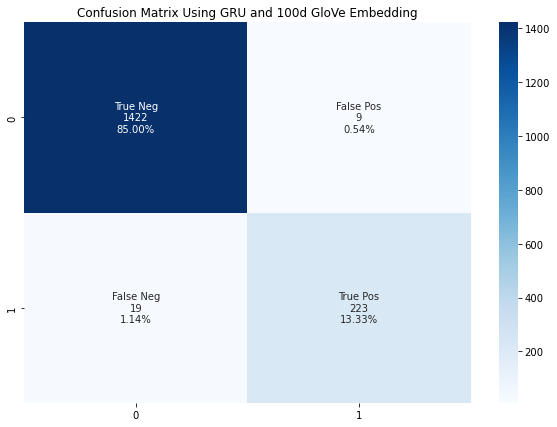

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix Using GRU and 100d GloVe Embedding")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

In [50]:

path_to_glove_file = "glove.6B.200d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [51]:
## Create "embedding_matrix" to index our vocabulary using the GloVe model 
num_tokens = len(voc) 
embedding_dim = 200 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
#create embedding layer
embedding_layer = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable=False,
)

Converted 5491 words (2405 misses)


In [52]:
print("Using GRU and 200d GloVe embedding")
# create model
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(len(classes), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()
# Train and fit the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, y_train, batch_size=128, epochs=20)
y_predict = model.predict(X_test, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
# Find precision and recall for each test set
print("------------------------------")
print("Using GRU and 200d GloVe embedding")
print("------------------------------")
print("Using the Whole Test Set -", y_test.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print("------------------------------")

Using GRU and 200d GloVe embedding
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 200)         1579200   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 40)         26640     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               7440      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 82        
                                                                 
Total params: 1,613,362


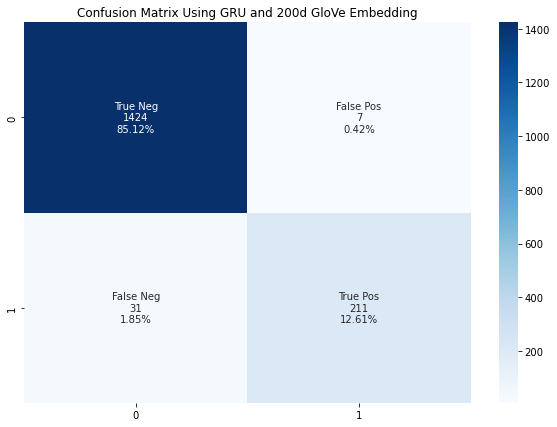

In [53]:
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix Using GRU and 200d GloVe Embedding")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

In [11]:
embedding_layer = Embedding(10000, 100,
                            input_length=X_train.shape[1])

In [12]:
print("Using GRU")
# create model
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(len(classes), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()
# Train and fit the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.fit(X_train, y_train, batch_size=128, epochs=20)
y_predict = model.predict(X_test, batch_size=128, verbose=0)
y_pred = np.argmax(y_predict, axis=1)
# Find precision and recall for each test set
print("------------------------------")
print("Using GRU")
print("------------------------------")
print("Using the Whole Test Set -", y_test.shape[0], "samples")
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))

print("------------------------------")


Using GRU
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 40)         14640     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               7440      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 82        
                                                                 
Total params: 1,022,162
Trainable params: 1,022,1